# Setting boundary conditions in PorePy
In this tutorial we will visit how to set boundary conditions for different model problems in PorePy.
In general, the setup is roughly as follows:
* Boundary condition type (Neumann or Dirichlet) is set by one method
* Boundary condition values are set through one or more methods

Internally in the code there are Neumann and Dirichlet filters being assigned according to the user's input in the boundary condition type method.
These filters make sure that only values set by a Dirichlet-method is assigned to Dirichlet boundaries, and similar for the Neumann case. For explaining this more thoroughly we will present some examples.


In [1]:
from porepy.applications.md_grids.domains import nd_cube_domain
import numpy as np
import porepy as pp


class ModifiedGeometry:
    def set_domain(self) -> None:
        """Defining a two-dimensional square domain with sidelength 2."""
        size = self.solid.convert_units(2, "m")
        self._domain = nd_cube_domain(2, size)

    def set_fractures(self) -> None:
        """Setting a diagonal fracture"""
        frac_1_points = self.solid.convert_units(
            np.array([[0.2, 1.8], [0.2, 1.8]]), "m"
        )
        frac_1 = pp.LineFracture(frac_1_points)
        self._fractures = [frac_1]

    def grid_type(self) -> str:
        """Choosing the grid type for our domain.

        As we have a diagonal fracture we cannot use a cartesian grid.
        Cartesian grid is the default grid type, and we therefore override this method to assign simplex instead.

        """
        return self.params.get("grid_type", "simplex")

    def meshing_arguments(self) -> dict:
        """Meshing arguments for md-grid creation.

        Here we determine the cell size.

        """
        cell_size = self.solid.convert_units(0.25, "m")
        mesh_args: dict[str, float] = {"cell_size": cell_size}
        return mesh_args

# The flow problem

There are multiple ways how to set the boundary conditions for the flow problem. We will list them and provide an example of how to apply them all.

## Setting the fluid mass flux
Consider the mass balance equation with zero source term:
$
\phi \dfrac{\partial \rho}{\partial t} + \nabla \cdot F = 0
$
, where $\phi \frac{\partial \rho}{\partial t}$ is the accumulation term, and $F$ is the fluid mass flux that flows in a cell. We can directly set the values of $F$ on boundary by:
* marking the boundary edges as `neu` in the `bc_type_fluid_flux` method
* providing the values of $F$ in `bc_values_fluid_flux`

Note that we provide only the normal component of $F$. If cells are marked as `dir` in `bc_type_fluid_flux`, the values of $F$ are computed based on the other types of boundary conditions.

Pro hint: the no-flux boundary condition can be applied by setting the zero values here.

In the example, we will set this boundary condition at the east side of the domain.

## Setting the Darcy flux
The expression for $F$ is the following:
$$
F = \dfrac{\rho}{\mu}K \nabla p
$$
where $\dfrac{\rho}{\mu}$ is the advected quantity and $K \nabla p$ is the Darcy flux.

In realistic setups, the values of $\rho$ and $\mu$ can depend on primary variables. For example, $\rho = \rho(p, T)$ and $\mu = \mu(T)$ in case of the non-isothermal fluid. It may be convenient to set the boundary condition in terms of the Darcy flux. The values for the advected quantity will be computed automatically. This helps prevent inconsistencies between expressions used to calculate these quantities on the boundary versus within the domain, which can cause notorious bugs. The Darcy flux boundary condition is applied by:
* ensuring that we do not use the boundary values for $F$ by checking that `bc_type_fluid_flux == dir` for our boundary edges
* setting the boundary edges as `neu` in `bc_type_darcy_flux`
* setting the values of primary variables that are used to evaluate $\rho$ and $\mu$ on the boundary in `bc_values_pressure` and the other methods corresponding to each variable in use
* setting the values for the Darcy flux in $bc_values_darcy_flux$

In the example, we will set this boundary condition at the west side of the domain.

## Setting pressure Dirichlet values
Finally, the Darcy flux can be evaluated by the provided pressure values. This is done by:
* ensuring that we do not use the boundary values for $F$ by checking that `bc_type_fluid_flux == dir` for our boundary edges
* setting the boundary edges as `dir` in `bc_type_darcy_flux`
* setting pressure values on the boundary in $bc_values_pressure$

In the example, we will set this boundary condition at the north side of the domain.

## Default behavior
By default, the Dirichlet pressure boundary condition is applied. The values are set by the reference pressure of the fluix. In the example, we will do nothing and contemplate the default behavior on the south side of the domain.

## Example: Single phase flow with various boundary conditions

In [5]:
import numpy as np
import porepy as pp

from porepy.models.fluid_mass_balance import SinglePhaseFlow

class SinglePhaseFlowWithBCs(ModifiedGeometry, SinglePhaseFlow):
    # In the following two methods, we will set the type of the boundary conditions

    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Boundary conditions on all external boundaries.

        Parameters:
            sd: Subdomain grid on which to define boundary conditions.

        Returns:
            Boundary condition object.

        """
        # Make the boundary condition type object with the default values.
        # By default, it assigns the Dirichlet type everythere.
        boundary_condition: pp.BoundaryCondition = super().bc_type_darcy_flux(sd)
        # Define boundary faces.
        boundary_faces = self.domain_boundary_sides(sd)

        # As mentioned above, we set the Darcy flux on the east side.
        # It repeats the default behavior, but we do it here as an exercise. 
        boundary_condition.is_neu[boundary_faces.east] = True
        boundary_condition.is_dir[boundary_faces.east] = False

        # We set the Dirichlet pressure values on the north side.
        boundary_condition.is_dir[boundary_faces.north] = True
        boundary_condition.is_neu[boundary_faces.north] = False

        # Finally, we do not change anything on the west and the south sides. 
        # The west side boundary condition is determined by the fluid mass flux.
        # The south side is left untouched to examinate the default behavior. 
        return boundary_condition
    
    def bc_type_fluid_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Boundary conditions on all external boundaries.

        Parameters:
            sd: Subdomain grid on which to define boundary conditions.

        Returns:
            Boundary condition object.

        """
        # Make the boundary condition type object with the default conditions.
        # The BoundaryCondition object by default assigns the Neumann type everythere.
        boundary_condition: pp.BoundaryCondition = super().bc_type_fluid_flux(sd)
        # Define boundary faces.
        boundary_faces = self.domain_boundary_sides(sd)

        # As mentioned above, we set the fluid mass flux on the west side.
        boundary_condition.is_neu[boundary_faces.west] = True
        boundary_condition.is_dir[boundary_faces.west] = False

        # Finally, we do not change anything on the other sides. 
        return boundary_condition
    
    # Below, we will set the values for the boundary conditions

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Pressure values for the Dirichlet boundary condition.

        Parameters:
            boundary_grid: Boundary grid to provide values for.

        Returns:
            An array with ``shape(boundary_grid.num_cells,)`` containing the pressure
            values on the provided boundary grid.

        """
        # Making the array with the default values. It consists of the reference
        # pressure values. 
        pressure_vals = super().bc_values_pressure(boundary_grid)
        domain_sides = self.domain_boundary_sides(boundary_grid)

        # Setting the values for the Dirichlet pressure boundary condition.
        pressure_vals[domain_sides.north] = 2e5 * self.units.Pa

        # Setting the other values for the Neumann Darcy flux boundary condition. These
        # values will be used to compute density.
        # pressure_vals[domain_sides.east] = 4e5 * self.units.Pa
        return pressure_vals

    def bc_values_darcy_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Volumetric Darcy flux values for the Neumann boundary condition.

        Parameters:
            boundary_grid: Boundary grid to provide values for.

        Returns:
            An array with ``shape=(boundary_grid.num_cells,)`` containing the volumetric
            Darcy flux values on the provided boundary grid.

        """
        # Creating the array with values.
        darcy_flux_vals = np.zeros(boundary_grid.num_cells)
        
        # Setting the values on the east boundary.
        domain_sides = self.domain_boundary_sides(boundary_grid)
        # darcy_flux_vals[domain_sides.east] = 2 * self.units.Pa / self.units.m
        return darcy_flux_vals


    def bc_values_fluid_flux(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        r"""Mass flux values on the Neumann boundary.

        Parameters:
            boundary_grid: Boundary grid to provide values for.

        Returns:
            An array with ``shape=(boundary_grid.num_cells,)`` containing the mass
            fluid flux values on the provided boundary grid.

        """
         # Creating the array with values.
        mass_flux_vals = np.zeros(boundary_grid.num_cells)

        # Setting the values on the west boundary.
        domain_sides = self.domain_boundary_sides(boundary_grid)
        # mass_flux_vals[domain_sides.west] = 0.0004 * self.units.kg / self.units.s
        return mass_flux_vals


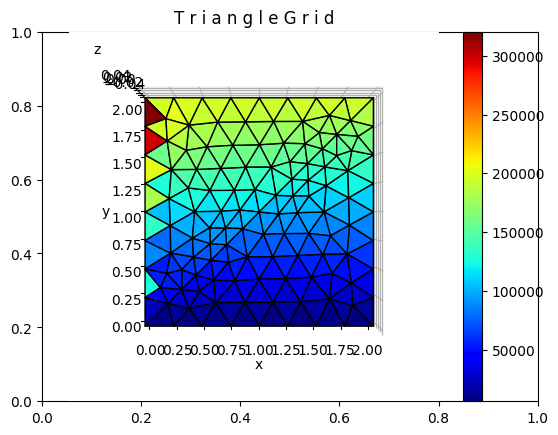

In [6]:
single_phase_flow = SinglePhaseFlowWithBCs(params={})
pp.run_time_dependent_model(single_phase_flow, params={})
pp.plot_grid(
    single_phase_flow.mdg.subdomains()[0],
    single_phase_flow.pressure(single_phase_flow.mdg.subdomains()).evaluate(
        single_phase_flow.equation_system
    ).val,
)

# The thermal problem

# The mechanics problem
Similar to the previous problems, we need to define one method for the type of boundary condition we are interested in, and another one for assigning the values. 
In the case of the mechanics problem we utilize the momentum balance model class. 
The momentum balance model class has the following methods predefined for setting boundary condition type and values:
* `bc_type_mechanics` for setting boundary condition type.
* `bc_values_displacement` for Dirichlet values.
* `bc_values_stress` for Neumann values.

As opposed to with the previous examples, this is a vector problem. 
Therefore we will here have to assign vectorial boundary condition values. 
This is shown below:


In [4]:
import numpy as np
import porepy as pp

class ModifiedBoundaryConditions:
    def bc_type_mechanics(self, sd: pp.Grid) -> pp.BoundaryConditionVectorial:
        bounds = self.domain_boundary_sides(sd)

        bc = pp.BoundaryConditionVectorial(sd, bounds.west, "dir")
        return bc

    def bc_values_stress(self, bg: pp.BoundaryGrid) -> np.ndarray:
        """Setting stress boundary conditions at north, south and east boundaries.
        
        Specifically, we assign different values for the x- and y-component of the boundary value vector.

        """
        values = np.ones((self.nd, bg.num_cells))
        bounds = self.domain_boundary_sides(bg)

        values[0][bounds.north + bounds.south] *= 1.5
        values[1][bounds.north + bounds.south] *= 0.5

        return values.ravel("F")

    def bc_values_displacement(self, bg: pp.BoundaryGrid) -> np.ndarray:
        """Setting displacement boundary conditions.
        
        This method returns an array of boundary condition values with the value 5 for all boundary x-components. However, since only the western boundary has the Dirichlet filter, the internal code will only consider the value 5 for the western boundary.
        
        """
        values = np.ones((self.nd, bg.num_cells))
    
        values[0] *= 5
        return values.ravel("F")
